In [1]:
# from dotenv import load_dotenv
# load_dotenv()

In [2]:
# import os
# os.environ['LD_LIBRARY_PATH'] = '/home/baris/miniconda3/envs/verifiers/lib/python3.11/site-packages/nvidia/nvjitlink/lib'

In [3]:
import json
import textwrap
import pandas as pd
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import HBox
import matplotlib.pyplot as plt
from tabulate import tabulate


In [4]:
filepath = "../data/generated/predictions.jsonl"
df = pd.read_json(filepath, lines=True)
df.head()

,id,answer,n_hops,prompt,docs,answers,supporting_doc_slugs,trajectory
0,2hop__734582_71302,Vito Corleone,2,[{'content': 'Answer the question based on the...,[{'body': 'Philippe Laguérie (born 30 Septembe...,"[vito andolini corleone, Vito Andolini Corleon...","[10. The Good Shepherd (film), 11. The Godfath...",[{'content': 'Answer the question based on the...
1,2hop__700093_455653,Rohana Wijeweera,2,[{'content': 'Answer the question based on the...,"[{'body': 'Political parties, still called fac...","[Rohana Wijeweera, rohana wijeweera]","[8. Rohana Wijeweera, 12. Dimuthu Bandara Abay...",[{'content': 'Answer the question based on the...
2,2hop__203955_25719,406,2,[{'content': 'Answer the question based on the...,[{'body': 'By the end of the 5th century the w...,[406],"[7. Rössen culture, 9. Galicia (Spain)]",[{'content': 'Answer the question based on the...
3,2hop__83800_747874,Jamie Murray,2,[{'content': 'Answer the question based on the...,[{'body': 'Kallhälls BK was a sports club in B...,"[Jamie Murray, jamie murray]","[8. 2011 Valencia Open 500 – Doubles, 16. 2016...",[{'content': 'Answer the question based on the...
4,2hop__21104_16334,modern-day Italians,2,[{'content': 'Answer the question based on the...,[{'body': 'Cyborg anthropology originated as a...,"[modern-day Italians, modern-day italians]","[4. Jews, 15. Ashkenazi Jews]",[{'content': 'Answer the question based on the...


In [5]:
from verifiers.rubrics.musique import extract_all_retrieved_doc_ids, get_last_answer


df["retrieved_doc_ids"] = df["trajectory"].apply(lambda x: list(extract_all_retrieved_doc_ids(x)))
df["missing_doc_ids"] = df.apply(
    lambda row: list(set(doc["id"] for doc in row["docs"] if doc["is_supporting"]) - set(row["retrieved_doc_ids"])),
    axis=1,
)
df["predicted_answer"] = df["trajectory"].apply(get_last_answer)

In [6]:
from verifiers.rubrics.musique import musique_f1_reward_func, musique_em_reward_func, musique_supporting_f1_reward_func, musique_supporting_recall_reward_func

em_rewards = musique_em_reward_func(df['trajectory'].values, df['answers'].values, [2] * len(df))
df['reward.em'] = em_rewards

f1_rewards = musique_f1_reward_func(df['trajectory'].values, df['answers'].values, [2] * len(df))
df['reward.f1'] = f1_rewards

supporting_f1_rewards = musique_supporting_f1_reward_func(df['trajectory'].values, df['docs'].values)
df['reward.supporting_f1'] = supporting_f1_rewards

supporting_recall_rewards = musique_supporting_recall_reward_func(df['trajectory'].values, df['docs'].values)
df['reward.supporting_recall'] = supporting_recall_rewards

In [7]:
df.head()

,id,answer,n_hops,prompt,docs,answers,supporting_doc_slugs,trajectory,retrieved_doc_ids,missing_doc_ids,predicted_answer,reward.em,reward.f1,reward.supporting_f1,reward.supporting_recall
0,2hop__734582_71302,Vito Corleone,2,[{'content': 'Answer the question based on the...,[{'body': 'Philippe Laguérie (born 30 Septembe...,"[vito andolini corleone, Vito Andolini Corleon...","[10. The Good Shepherd (film), 11. The Godfath...",[{'content': 'Answer the question based on the...,"[10, 6]",[11],Lenny Montana,0.0,0.000000,0.500000,0.5
1,2hop__700093_455653,Rohana Wijeweera,2,[{'content': 'Answer the question based on the...,"[{'body': 'Political parties, still called fac...","[Rohana Wijeweera, rohana wijeweera]","[8. Rohana Wijeweera, 12. Dimuthu Bandara Abay...",[{'content': 'Answer the question based on the...,[12],[8],Rohana Wijeweera,1.0,1.000000,0.666667,0.5
2,2hop__203955_25719,406,2,[{'content': 'Answer the question based on the...,[{'body': 'By the end of the 5th century the w...,[406],"[7. Rössen culture, 9. Galicia (Spain)]",[{'content': 'Answer the question based on the...,"[7, 7, 6]",[9],<cite>6</cite> 410,0.0,0.000000,0.500000,0.5
3,2hop__83800_747874,Jamie Murray,2,[{'content': 'Answer the question based on the...,[{'body': 'Kallhälls BK was a sports club in B...,"[Jamie Murray, jamie murray]","[8. 2011 Valencia Open 500 – Doubles, 16. 2016...",[{'content': 'Answer the question based on the...,"[16, 8]",[],Jamie Murray is the sibling of the player who ...,0.0,0.266667,1.000000,1.0
4,2hop__21104_16334,modern-day Italians,2,[{'content': 'Answer the question based on the...,[{'body': 'Cyborg anthropology originated as a...,"[modern-day Italians, modern-day italians]","[4. Jews, 15. Ashkenazi Jews]",[{'content': 'Answer the question based on the...,"[14, 14]","[15, 4]",None,0.0,0.000000,0.000000,0.0


In [8]:
df[['reward.em', 'reward.f1', 'reward.supporting_f1', 'reward.supporting_recall']].describe()

,reward.em,reward.f1,reward.supporting_f1,reward.supporting_recall
count,300.00000,300.000000,300.000000,300.000000
mean,0.29000,0.389241,0.678325,0.616944
std,0.45452,0.437248,0.266441,0.287231
min,0.00000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.500000,0.500000
50%,0.00000,0.167347,0.666667,0.666667
75%,1.00000,1.000000,0.857143,1.000000
max,1.00000,1.000000,1.000000,1.000000


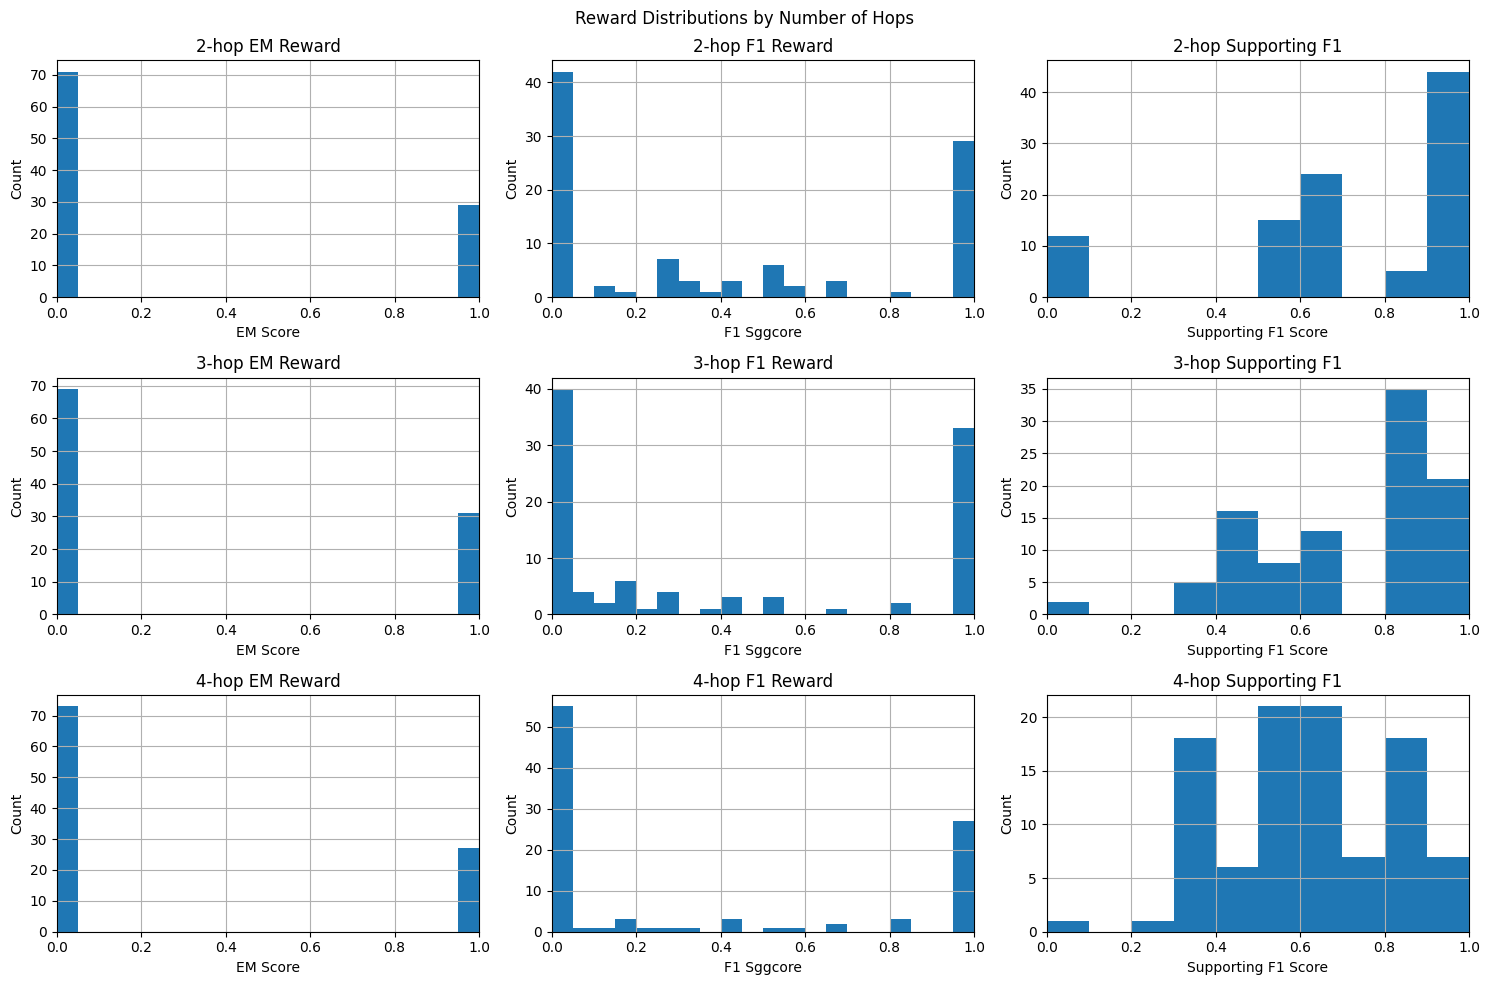

In [9]:
# Visualize rewards per n_hops
n_hops = sorted(df['n_hops'].unique())
fig, axes = plt.subplots(len(n_hops), 3, figsize=(15, 10))
fig.suptitle('Reward Distributions by Number of Hops')

for i, n_hop in enumerate(n_hops):
    subset = df[df['n_hops'] == n_hop]
    
    subset['reward.em'].hist(ax=axes[i,0], bins=20)
    axes[i,0].set_title(f'{n_hop}-hop EM Reward')
    axes[i,0].set_xlabel('EM Score')
    axes[i,0].set_ylabel('Count')
    axes[i,0].set_xlim(0, 1)
    
    subset['reward.f1'].hist(ax=axes[i,1], bins=20)
    axes[i,1].set_title(f'{n_hop}-hop F1 Reward')
    axes[i,1].set_xlabel('F1 Sggcore')
    axes[i,1].set_ylabel('Count')
    axes[i,1].set_xlim(0, 1)
    
    subset['reward.supporting_f1'].hist(ax=axes[i,2])
    axes[i,2].set_title(f'{n_hop}-hop Supporting F1')
    axes[i,2].set_xlabel('Supporting F1 Score')
    axes[i,2].set_ylabel('Count')
    axes[i,2].set_xlim(0, 1)


plt.tight_layout()


In [10]:
row = df.iloc[0]
row['prompt']

[{'content': 'Answer the question based on the information provided by tools. You have access to the following tools:\n====\nsearch: Retrieve for relevant documents by the query. The results become better if the query is more specific. It excludes documents that have already been retrieved.\n\nArguments:\n  - query: \n----\nget_doc: Get the document by the id.\n\nArguments:\n  - id: \n====\n\nFor each step:\n1. Think through your reasoning inside <think> tags\n2. If needed, use a tool by writing a JSON command inside <tool> tags with:\n   - "name": the tool to use\n   - "args": the arguments for the tool\nFor instance,\n<tool>\n{\n  "name": "search",\n  "args": {\n    "query": "..."\n  }\n}\n</tool>\n3. You will see the tool\'s output inside <result> tags\n4. Continue until you have found the answer\n5. In the **last** step, \n  - Reflect on your previous steps inside <think> tags\n  - Cite the documents you used to answer the question inside <cite> tags by their IDs, e.g. `<cite>1, 2,

In [13]:
import textwrap
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import HBox

def fixedwidth(text):
    if not isinstance(text, str):
        text = str(text)
    return "\n".join(textwrap.wrap(text, width=80, replace_whitespace=False))

def format_conversation(messages: list[dict]) -> str:
    return "\n".join([f"{msg['role']}: {msg['content']}" for msg in messages])

def format_row(row):
    question = row['prompt'][-1]['content']
    idx_of_question = next((i for i, msg in enumerate(row['trajectory']) if msg['role'] == 'user' and msg['content'] == question), None)
    output = []
    output.append(f"{row['id']} - {row['n_hops']} hops")
    output.append("="*80)
    output.append("Q: " + row['prompt'][-1]['content'])
    output.append("Reference Answers: " + str(row['answers']))
    output.append("Predicted Answer: " + str(row['predicted_answer']))
    output.append("")
    output.append("# Scores")
    output.append("EM: {:.3f}".format(row['reward.em']))
    output.append("F1: {:.3f}".format(row['reward.f1']))
    output.append("Supporting F1: {:.3f}".format(row['reward.supporting_f1']))
    output.append("Supporting Recall: {:.3f}".format(row['reward.supporting_recall']))
    output.append("")
    # output.append("Supporting Titles: " + str(row['supporting_titles']))
    # output.append("Retrieved Titles: " + str(row['retrieved_titles']))
    # output.append("Missing Titles: " + str(row['missing_titles']))
    output.append("\n")
    output.append("="*80)
    output.append(format_conversation(row['trajectory'][idx_of_question:]))
    output.append("="*80)
    return "\n".join(output)

def present_row(row):
    print(format_row(row))

def create_browse_app(dataf):
    def browse_failed(i=0):
        row = dataf.iloc[i]
        present_row(row)

    index = widgets.IntText(value=0, description='Index:')
    left_button = widgets.Button(description='Previous')
    right_button = widgets.Button(description='Next')

    def on_left_button_clicked(b):
        if index.value > 0:
            index.value -= 1

    def on_right_button_clicked(b):
        if index.value < len(dataf) - 1:
            index.value += 1

    left_button.on_click(on_left_button_clicked)
    right_button.on_click(on_right_button_clicked)

    ui = HBox([left_button, index, right_button])
    out = widgets.interactive_output(browse_failed, {'i': index})

    display(ui, out)

# Create app focused on failed examples
inspect_df = df[df['reward.f1'] < 1.0].sort_values('reward.f1')
create_browse_app(inspect_df)


Output()

In [14]:
retrieval_failure_mask = df['reward.supporting_recall'] < 0.95
retrieval_failure_mask.sum() / len(df)

0.7233333333333334

In [15]:
reasoning_failure_mask = (df['reward.f1'] < 0.5) & ~retrieval_failure_mask
reasoning_failure_mask.sum() / len(df)

0.10333333333333333

In [20]:
unfaithful_success_mask = (df['reward.f1'] > 0.5) & retrieval_failure_mask
unfaithful_success_mask.sum() / len(df)

0.17333333333333334

In [21]:
create_browse_app(df.loc[retrieval_failure_mask])

Output()